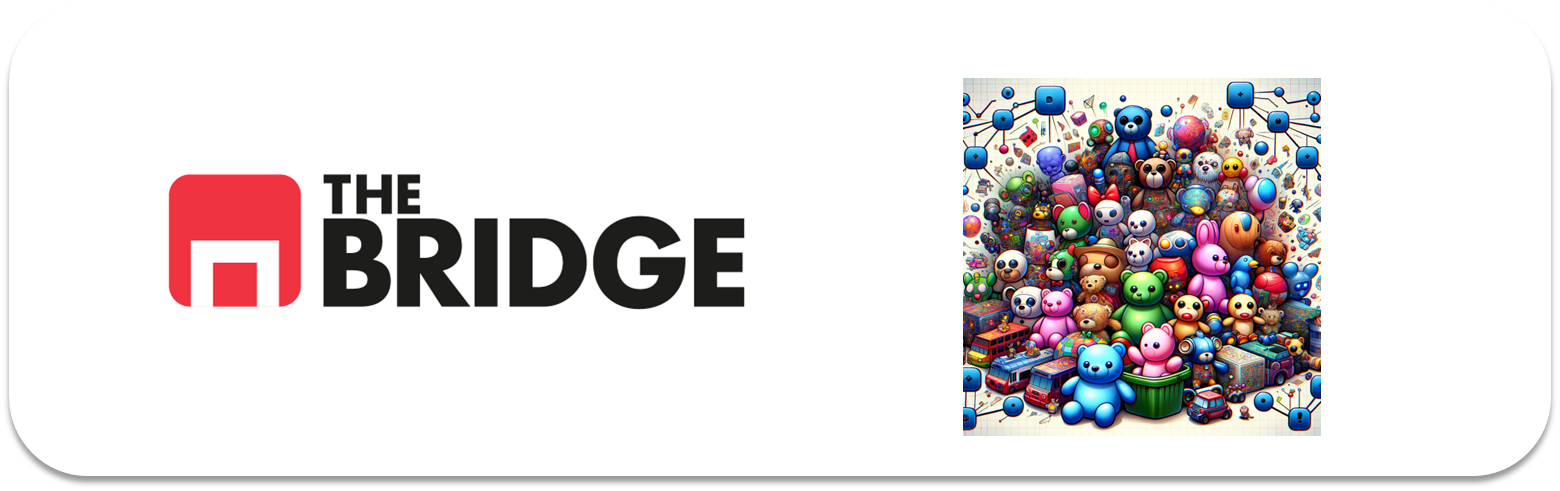

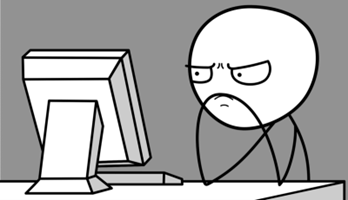

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es especulativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


Problema No supervisado : no tenemos target
Intentar clusterizar -min 3 max 5 - para saber que mezclas probar/prototipar indicando los porcentage de cada bebida

In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", sep='|')

In [4]:
df.columns

Index(['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico',
       'Taurina'],
      dtype='object')

In [3]:
df

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783
149,0.332758,-0.389355,-1.344582,0.280575,2.224236
150,0.209232,0.012732,-1.354622,0.296498,1.834923
151,1.395086,1.365208,-1.274305,-0.595160,1.791666


In [7]:
df.describe()

# las features ya estàn escaladas : 
# todas tienen media alrededor de zero y std alrededor de 1

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


<Figure size 1500x1000 with 0 Axes>

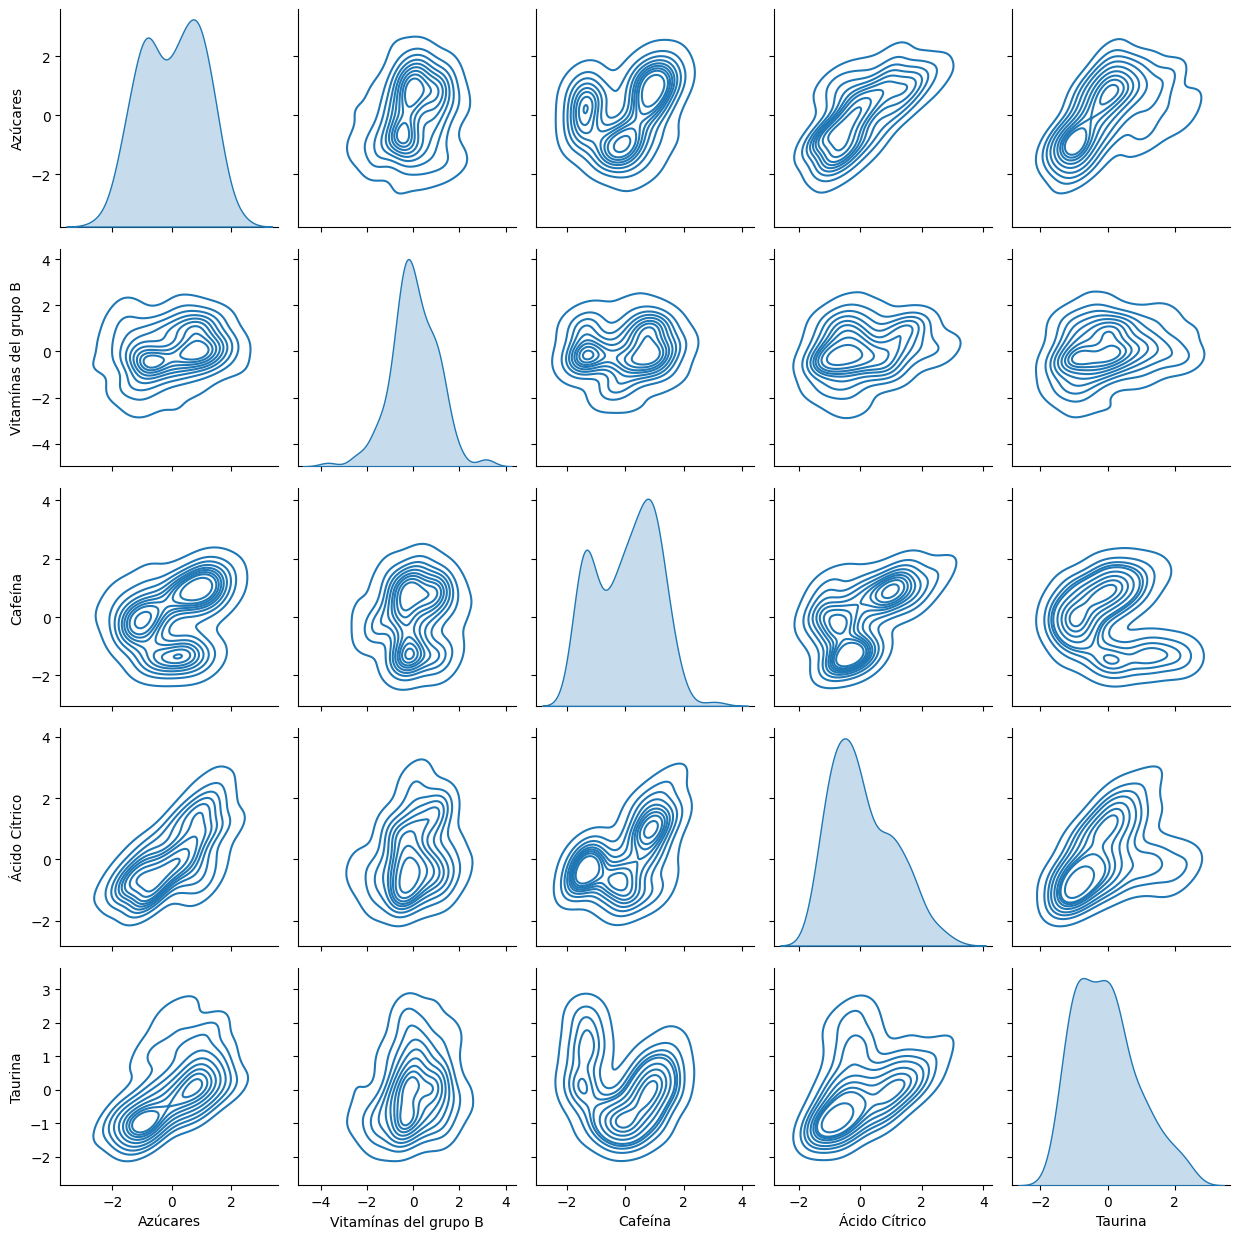

In [48]:
plt.figure(figsize=(15, 10))
sns.pairplot(df, kind = 'kde')
plt.tight_layout()

Text(0.5, 1.0, 'Matriz de Correlaciones')

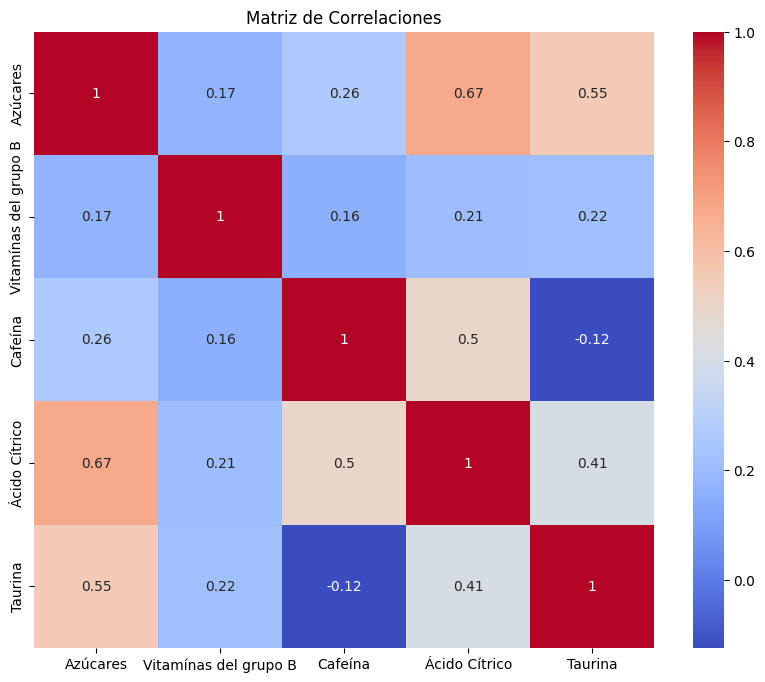

In [44]:
# 3. Mini EDA y selección de features
correlations = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaciones')

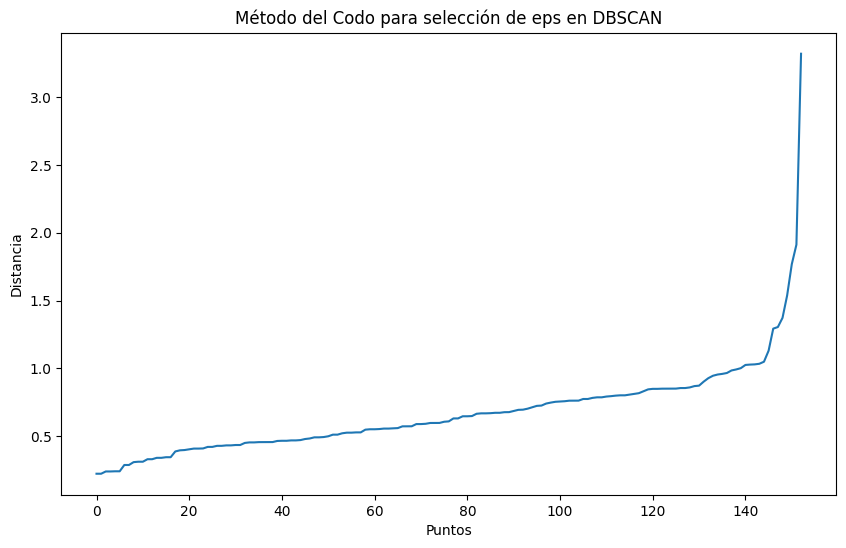

In [61]:
# DBSCAN
# Calculamos eps usando el método del codo con los k-vecinos más cercanos
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Método del Codo para selección de eps en DBSCAN')
plt.xlabel('Puntos')
plt.ylabel('Distancia')

# Seleccionamos eps basándonos en el gráfico anterior
eps = 1 # Este valor se ajustaría según el gráfico
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

In [62]:
dbscan_labels

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  1, -1,  1,  1,  0, -1, -1, -1,  1, -1,  1,
        0, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2, -1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2])

In [64]:
pd.Series(dbscan_labels).nunique()

4

In [63]:
pd.Series(dbscan_labels).unique()

array([ 0, -1,  1,  2])

In [69]:
# porcentaje de anomalias -1
sum(dbscan_labels == -1) / len(dbscan_labels)

np.float64(0.1830065359477124)

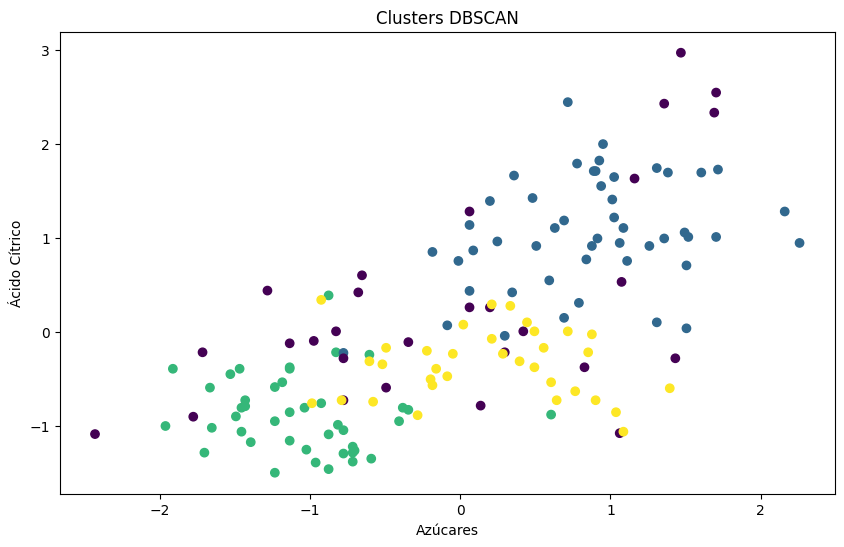

In [47]:
# 6. Visualización de resultados
def plot_clusters(data, labels, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Azúcares'], data['Ácido Cítrico'], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('Azúcares')
    plt.ylabel('Ácido Cítrico')

#plot_clusters(df, kmeans_labels, 'Clusters K-means')
plot_clusters(df, dbscan_labels, 'Clusters DBSCAN')

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.